In [3]:
!pip install scikit-image

     |████████████████████████████████| 12.4 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 96.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 79.3 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 101.4 MB/s eta 0:00:01


In [5]:
import sys
sys.path.insert(0,'src')

In [8]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [28]:
from visualize_attention import apply_mask, random_colors, display_instances
import vision_transformer as vits

In [21]:
class obj(object):
    pass

args = obj()

In [90]:
args.arch='vit_base'
args.patch_size=8
args.pretrained_weights='pretrained/dino_vitbase8_pretrain_full_checkpoint.pth'
args.checkpoint_key='teacher'
args.image_path='../afex-1k/test/0062802798/AFEX_09c2c307-af75-42ac-a789-316f1988f1aa_MSP1_F2_L1_1618890409113_ICR890_crop.jpg'
args.image_size=(480,480)
args.output_dir='../afex-1k/viz/{}'.format(args.image_path.split('/')[-2])
args.output_filename=args.image_path.split('/')[-1]
args.threshold=0.80
args.mean=np.load('../afex-1k/test-mean.npy')
args.std=np.load('../afex-1k/test-std.npy')

In [69]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)

state_dict = torch.load(args.pretrained_weights, map_location="cpu")
if args.checkpoint_key is not None and args.checkpoint_key in state_dict:
    print(f"Take key {args.checkpoint_key} in provided checkpoint dict")
    state_dict = state_dict[args.checkpoint_key]
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)
print('Pretrained weights found at {} and loaded with msg: {}'.format(args.pretrained_weights, msg))



import torchvision.transforms.functional as F

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')
    
transform = pth_transforms.Compose([
    SquarePad(),
    pth_transforms.Resize(args.image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(args.mean, args.std),
])

In [93]:
with open(args.image_path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')

img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // args.patch_size
h_featmap = img.shape[-1] // args.patch_size

attentions = model.get_last_selfattention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

if args.threshold is not None:
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - args.threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0].cpu().numpy()

os.makedirs(args.output_dir, exist_ok=True)

output_path = os.path.join(args.output_dir, args.output_filename)

#torchvision.utils.save_image(torchvision.utils.make_grid(attentions, normalize=True, scale_each=True), output_path)

test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.
test saved.


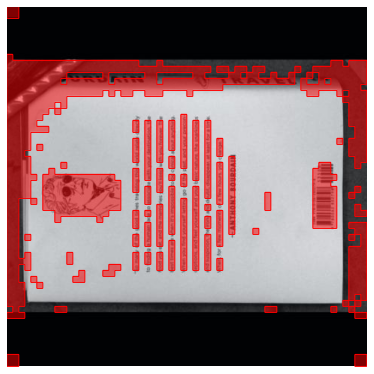

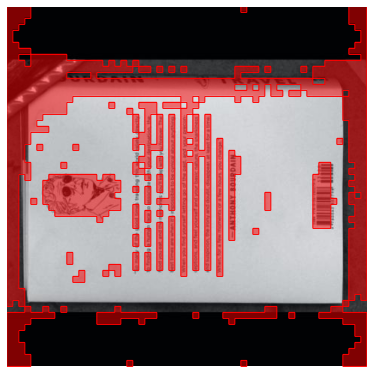

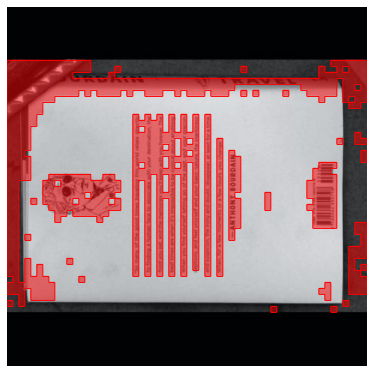

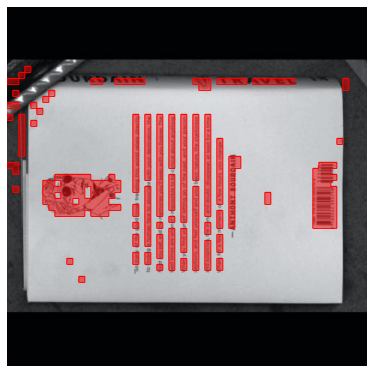

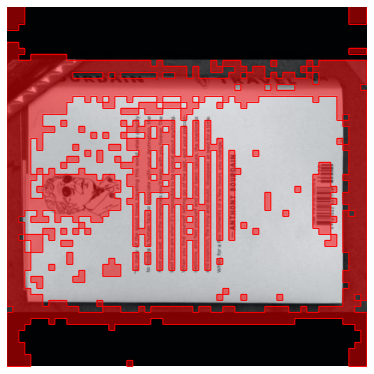

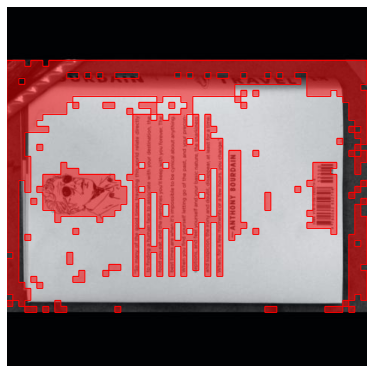

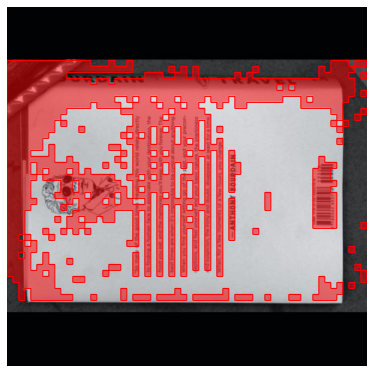

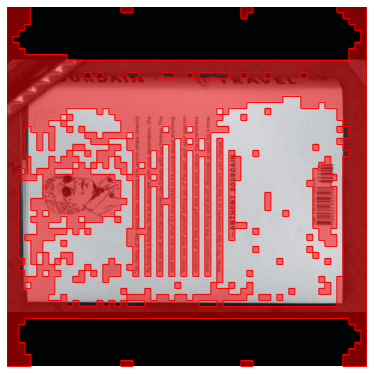

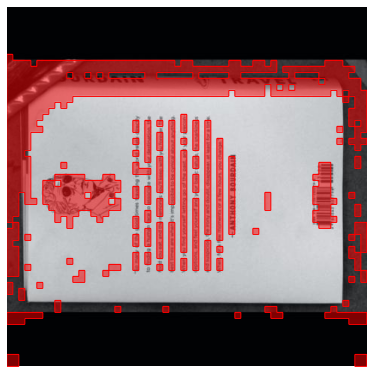

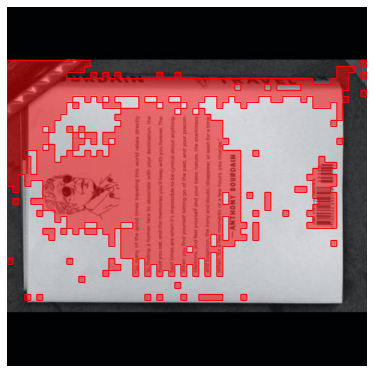

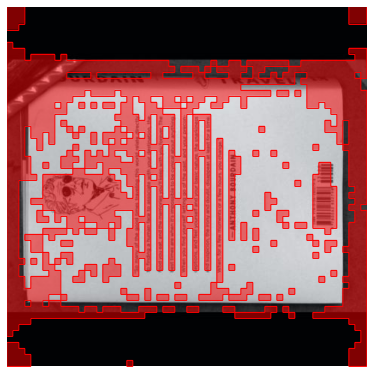

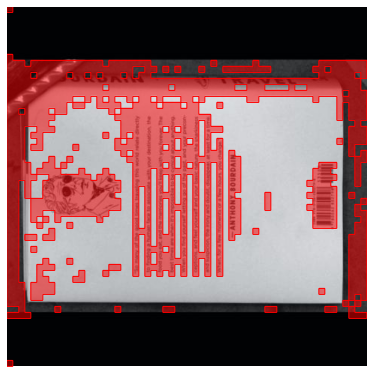

In [94]:
image = skimage.io.imread(output_path)
for j in range(nh):
    display_instances(image, th_attn[j], blur=False)

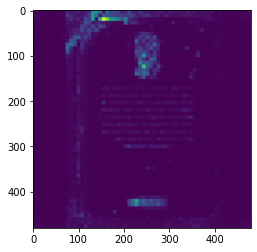

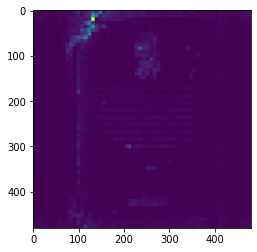

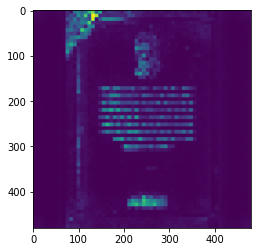

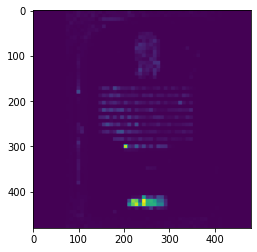

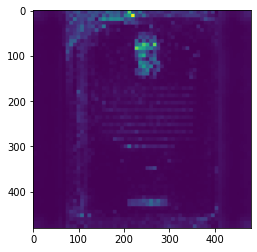

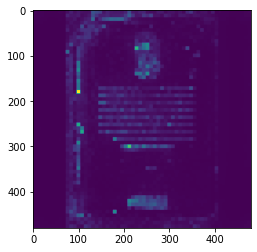

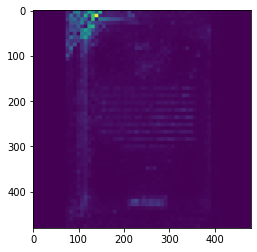

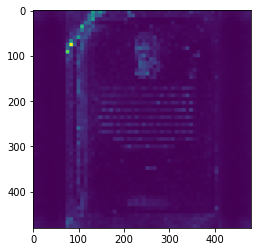

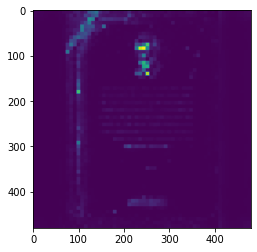

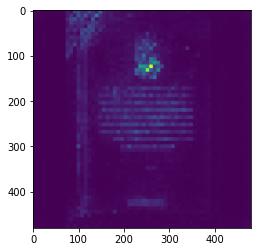

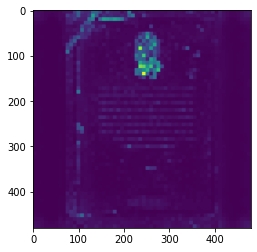

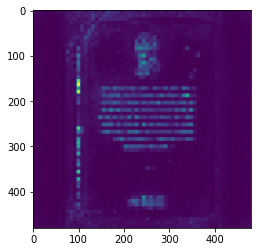

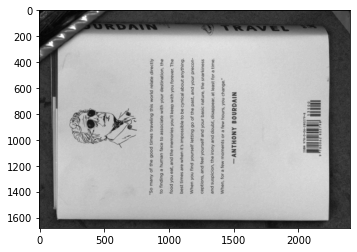

In [92]:
for j in range(nh):
    plt.imshow(attentions[j].T)
    plt.show()
plt.imshow(plt.imread(args.image_path))